In [ ]:
!pwd

#mounting drive
from google.colab import drive
drive.mount('/content/drive')

!ls

# java install
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!ls /usr/lib/jvm/

# spark download & extract
!wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

!tar -xvzf spark-3.5.1-bin-hadoop3.tgz

#install findspark
!pip install -q findspark

#install pyspark
!pip install pyspark

# install constraction
!pip install contractions

!pip install wordcloud

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive	     spark-3.5.1-bin-hadoop3	  spark-3.5.1-bin-hadoop3.tgz.1
sample_data  spark-3.5.1-bin-hadoop3.tgz
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lis

In [ ]:

# initialize the environment for Apache Spark
import findspark
findspark.init()

#import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3.tgz"


In [ ]:
from pyspark.sql.functions import col, sum as spark_sum
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import contractions
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer, Tokenizer, StopWordsRemover, CountVectorizer, IDF, VectorAssembler


In [ ]:
spark = SparkSession.builder \
        .master("local") \
        .appName("BDA_AAT") \
        .config("spark.sql.execution.arrow.enabled", "true") \
        .getOrCreate()


In [ ]:
df1 = spark.read.format('parquet').options(header='true').load('/content/drive/MyDrive/BDA AAT/train-00000-of-00001-02c2eb995e9506ad.parquet')
df2= spark.read.format('parquet').options(header='true').load('/content/drive/MyDrive/BDA AAT/test-00000-of-00001-6c0cd69b1acf877e.parquet')

In [ ]:
df1.show(5)

+-----+-----------------+------------------+--------------+--------------------+
|brand|primaryCategories|reviews.numHelpful|reviews.rating|        reviews.text|
+-----+-----------------+------------------+--------------+--------------------+
|    2|  Health & Beauty|              NULL|             5|Amazon's batterie...|
|    2|  Health & Beauty|              NULL|             5|always need batte...|
|    0|      Electronics|               0.0|             4|It's pretty good ...|
|    0|      Electronics|               0.0|             4|I love it it come...|
|    0|      Electronics|               0.0|             4|For the price, it...|
+-----+-----------------+------------------+--------------+--------------------+
only showing top 5 rows



In [ ]:
df2.show(5)

+-----+-----------------+------------------+--------------+--------------------+
|brand|primaryCategories|reviews.numHelpful|reviews.rating|        reviews.text|
+-----+-----------------+------------------+--------------+--------------------+
|    2|  Health & Beauty|              NULL|             4|A lot of battery ...|
|    0|      Electronics|               0.0|             4|Great tablet for ...|
|    2|  Health & Beauty|              NULL|             1|I love Amazon and...|
|    2|  Health & Beauty|              NULL|             5|Fast delivery of ...|
|    2|  Health & Beauty|              NULL|             4|Battery life is e...|
+-----+-----------------+------------------+--------------+--------------------+
only showing top 5 rows



In [ ]:
df1.printSchema()

root
 |-- brand: long (nullable = true)
 |-- primaryCategories: string (nullable = true)
 |-- reviews.numHelpful: double (nullable = true)
 |-- reviews.rating: long (nullable = true)
 |-- reviews.text: string (nullable = true)



In [ ]:
print(df1.count())
print(df2.count())

6000
2000


In [ ]:
train=df1

In [ ]:
test=df2

In [ ]:
train = train.drop("brand", "primaryCategories",'reviews.numHelpful','reviews.rating')
test= test.drop("brand", "primaryCategories",'reviews.numHelpful','reviews.rating')

In [ ]:
train = train.withColumnRenamed("reviews.text", "reviews")
test = test.withColumnRenamed("reviews.text", "reviews")


In [ ]:
train.show(2)

+--------------------+
|             reviews|
+--------------------+
|Amazon's batterie...|
|always need batte...|
+--------------------+
only showing top 2 rows



In [ ]:
test.show(2)

+--------------------+
|             reviews|
+--------------------+
|A lot of battery ...|
|Great tablet for ...|
+--------------------+
only showing top 2 rows



In [ ]:

# Download necessary resources for NLTK
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
tokenizer = Tokenizer(inputCol='reviews', outputCol='tokenized_text')
train = tokenizer.transform(train)
test = tokenizer.transform(test)

stop_remove = StopWordsRemover(inputCol='tokenized_text', outputCol='token_stop')
train = stop_remove.transform(train)
test = stop_remove.transform(test)

In [ ]:

# Define the Lemmatizer
lemmatizer = WordNetLemmatizer()

def cleaner(text):
    new_text = re.sub(r"'s\b", " is", text)
    new_text = re.sub("#", "", new_text)
    new_text = re.sub("@[A-Za-z0-9]+", "", new_text)
    new_text = re.sub(r"http\S+", "", new_text)
    new_text = contractions.fix(new_text)
    new_text = re.sub(r"[^a-zA-Z]", " ", new_text)
    new_text = new_text.lower().strip()

    cleaned_text = ''
    for token in new_text.split():
        cleaned_text = cleaned_text + lemmatizer.lemmatize(token) + ' '

    return cleaned_text


In [ ]:

# Preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        # cleaner function
        cleaned_text = cleaner(text)

        # Tokenization
        tokens = word_tokenize(cleaned_text)

        # Remove punctuation
        tokens = [token for token in tokens if token not in string.punctuation]

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        # Reconstruct preprocessed text
        preprocessed_text = ' '.join(tokens)
        return preprocessed_text
    else:
        # If the input is not a string, return an empty string
        return ''

In [ ]:
# Define the UDF for preprocessing text
preprocess_text_udf = udf(preprocess_text, StringType())

# Apply the UDF to 'reviews_text' column and create a new column 'cleaned_reviews'
train = train.withColumn('cleaned_reviews', preprocess_text_udf(train['reviews']))
# Apply the UDF to 'reviews_text' column and create a new column 'cleaned_reviews'
test = test.withColumn('cleaned_reviews', preprocess_text_udf(test['reviews']))

In [ ]:
# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define a UDF for sentiment analysis
def analyze_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores["compound"]

analyze_sentiment_udf = udf(analyze_sentiment, StringType())

In [ ]:
train = train.withColumn("SENTIMENT_SCORE", analyze_sentiment_udf(train["cleaned_reviews"]))
test = test.withColumn("SENTIMENT_SCORE", analyze_sentiment_udf(test["cleaned_reviews"]))

In [ ]:
def classify_sentiment(text):
  """
  Classifies the sentiment of a text string as positive, negative, or neutral.
  """
  score = sia.polarity_scores(text)

  if score['compound'] > 0.6:
    return 'positive'
  elif score['compound'] < -0.5:  # Adjust threshold for neutral as needed
    return 'negative'
  else:
    return 'neutral'

classify_sentiment_udf = udf(classify_sentiment, StringType())


In [ ]:
train=train.withColumn("SENTIMENT_CLASS", classify_sentiment_udf(train["cleaned_reviews"]))
test=test.withColumn("SENTIMENT_CLASS", classify_sentiment_udf(test["cleaned_reviews"]))

In [ ]:
train.show()

+--------------------+--------------------+--------------------+--------------------+---------------+---------------+
|             reviews|      tokenized_text|          token_stop|     cleaned_reviews|SENTIMENT_SCORE|SENTIMENT_CLASS|
+--------------------+--------------------+--------------------+--------------------+---------------+---------------+
|Amazon's batterie...|[amazon's, batter...|[amazon's, batter...|amazon battery gr...|           0.93|       positive|
|always need batte...|[always, need, ba...|[always, need, ba...| always need battery|            0.0|        neutral|
|It's pretty good ...|[it's, pretty, go...|[pretty, good, de...|pretty good desig...|         0.9571|       positive|
|I love it it come...|[i, love, it, it,...|[love, comes, 12,...|love come month k...|         0.6369|       positive|
|For the price, it...|[for, the, price,...|[price,, quite, n...|price quite nice ...|         0.7645|       positive|
|This tablet is go...|[this, tablet, is...|[tablet, good

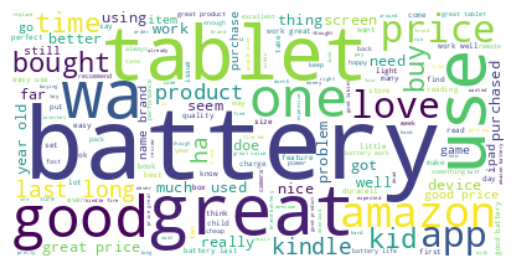

In [ ]:
# Import the necessary libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Preprocess the text data
preprocessed_text = train.select('cleaned_reviews').rdd.flatMap(lambda x: x).collect()
text = ' '.join(preprocessed_text)

# Generate the word cloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
test.show()

+--------------------+--------------------+--------------------+--------------------+---------------+---------------+
|             reviews|      tokenized_text|          token_stop|     cleaned_reviews|SENTIMENT_SCORE|SENTIMENT_CLASS|
+--------------------+--------------------+--------------------+--------------------+---------------+---------------+
|A lot of battery ...|[a, lot, of, batt...|[lot, battery, bu...|    lot battery buck|            0.0|        neutral|
|Great tablet for ...|[great, tablet, f...|[great, tablet, t...|great tablet todd...|         0.9612|       positive|
|I love Amazon and...|[i, love, amazon,...|[love, amazon, am...|love amazon amazo...|         0.6705|       positive|
|Fast delivery of ...|[fast, delivery, ...|[fast, delivery, ...|fast delivery pro...|            0.0|        neutral|
|Battery life is e...|[battery, life, i...|[battery, life, e...|battery life equi...|         0.9195|       positive|
|My sons face lit ...|[my, sons, face, ...|[sons, face, 

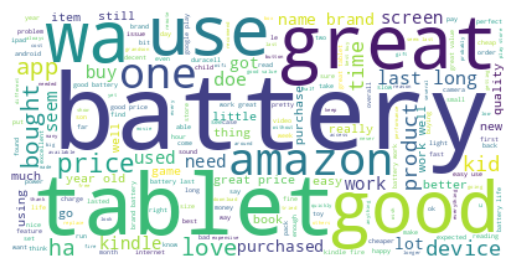

In [ ]:
# Import the necessary libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Preprocess the text data
preprocessed_text = test.select('cleaned_reviews').rdd.flatMap(lambda x: x).collect()
text = ' '.join(preprocessed_text)

# Generate the word cloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
train=train.drop("reviews","tokenized_text","token_stop","SENTIMENT_SCORE")

In [ ]:
test=test.drop("reviews","tokenized_text","token_stop","SENTIMENT_SCORE")

In [ ]:
train.show(5)

+--------------------+---------------+
|     cleaned_reviews|SENTIMENT_CLASS|
+--------------------+---------------+
|amazon battery gr...|       positive|
| always need battery|        neutral|
|pretty good desig...|       positive|
|love come month k...|       positive|
|price quite nice ...|       positive|
+--------------------+---------------+
only showing top 5 rows



In [ ]:
test.show(5)

+--------------------+---------------+
|     cleaned_reviews|SENTIMENT_CLASS|
+--------------------+---------------+
|    lot battery buck|        neutral|
|great tablet todd...|       positive|
|love amazon amazo...|       positive|
|fast delivery pro...|        neutral|
|battery life equi...|       positive|
+--------------------+---------------+
only showing top 5 rows



In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
tokenizer = Tokenizer(inputCol="cleaned_reviews", outputCol="words")
# Convert words to feature vectors
vectorizer = CountVectorizer(inputCol="words", outputCol="raw_features")
# Compute IDF
idf = IDF(inputCol="raw_features", outputCol="features")
# Convert labels to numeric indices
label_indexer = StringIndexer(inputCol="SENTIMENT_CLASS", outputCol="label")


# Step 4: Model Selection
# Define models
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8)
rf = RandomForestClassifier(numTrees=100, maxDepth=4, labelCol="label", seed=42)
# Define Naive Bayes classifier
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

lr_pipeline = Pipeline(stages=[tokenizer, vectorizer, idf, label_indexer, lr])
rf_pipeline = Pipeline(stages=[tokenizer, vectorizer, idf, label_indexer, rf])
# Define pipelines for Naive Bayes and SVM
nb_pipeline = Pipeline(stages=[tokenizer, vectorizer, idf, label_indexer, nb])



# Train models
lr_model = lr_pipeline.fit(train)
rf_model = rf_pipeline.fit(train)
# Train Naive Bayes model
nb_model = nb_pipeline.fit(train)


# Step 5: Evaluate Model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Evaluate Logistic Regression Model
lr_predictions = lr_model.transform(test)
lr_accuracy = evaluator.evaluate(lr_predictions)
print("Logistic Regression Model Accuracy:", lr_accuracy)

# Evaluate Random Forest Model
rf_predictions = rf_model.transform(test)
rf_accuracy = evaluator.evaluate(rf_predictions)
print("Random Forest Model Accuracy:", rf_accuracy)

# Evaluate Naive Bayes Model
nb_predictions = nb_model.transform(test)
nb_accuracy = evaluator.evaluate(nb_predictions)
print("Naive Bayes Model Accuracy:", nb_accuracy)



Logistic Regression Model Accuracy: 0.497
Random Forest Model Accuracy: 0.7735
Naive Bayes Model Accuracy: 0.7455


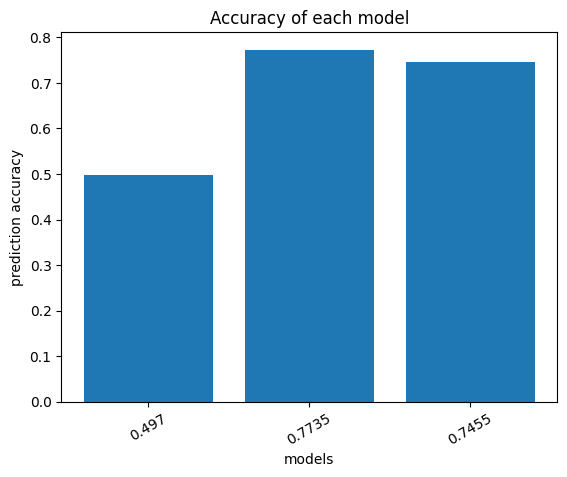

In [ ]:
import numpy as np
best_accuracy = (lr_accuracy, rf_accuracy, nb_accuracy)
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(best_accuracy))
    plt.bar(index, best_accuracy)
    plt.xlabel('models', fontsize=10)
    plt.ylabel('prediction accuracy', fontsize=10)
    plt.xticks(index, best_accuracy, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()

plot_bar_x()

In [ ]:
# Load the Parquet file
input_data = spark.read.parquet("/content/drive/MyDrive/BDA AAT/amazon_updated.parquet")


In [ ]:
input_data.show()

+--------------------+-----------------+
|                text|__index_level_0__|
+--------------------+-----------------+
|A lot of battery ...|                0|
|Great tablet for ...|                1|
|I love Amazon and...|                2|
|Fast delivery of ...|                3|
|Battery life is e...|                4|
|My sons face lit ...|                5|
|I use this tablet...|                6|
|  Still going strong|                7|
|Clear screen, but...|                8|
|My kids have enjo...|                9|
|Ordering more. Wh...|               10|
|            its okay|               11|
|           They work|               12|
|Great for watchin...|               13|
|These are so far ...|               14|
|Very durable and ...|               15|
|Works well. But d...|               16|
|My 5 year old lov...|               17|
|The amazon fire O...|               18|
|Needs to be more ...|               19|
+--------------------+-----------------+
only showing top

In [ ]:
pred= input_data.drop("__index_level_0__")

In [ ]:
pred = pred.withColumn('cleaned_reviews', pred['text'])

In [ ]:
pred=pred.drop("text")

In [ ]:
pred.show()

+--------------------+
|     cleaned_reviews|
+--------------------+
|A lot of battery ...|
|Great tablet for ...|
|I love Amazon and...|
|Fast delivery of ...|
|Battery life is e...|
|My sons face lit ...|
|I use this tablet...|
|  Still going strong|
|Clear screen, but...|
|My kids have enjo...|
|Ordering more. Wh...|
|            its okay|
|           They work|
|Great for watchin...|
|These are so far ...|
|Very durable and ...|
|Works well. But d...|
|My 5 year old lov...|
|The amazon fire O...|
|Needs to be more ...|
+--------------------+
only showing top 20 rows



In [ ]:
# Preprocess the test data using the same transformations
preprocessed_data = rf_model.transform(pred)

# Select only the necessary columns for prediction and save to Parquet
prediction_result = preprocessed_data.select("features", "prediction")

In [ ]:
prediction_result.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(4792,[0,49],[1.3...|       1.0|
|(4792,[1,3,13,23,...|       0.0|
|(4792,[7,13,15,21...|       0.0|
|(4792,[16,88,698]...|       1.0|
|(4792,[0,14,19,23...|       0.0|
|(4792,[17,56,66,1...|       0.0|
|(4792,[1,3,8,193,...|       0.0|
|(4792,[62,163,530...|       1.0|
|(4792,[56,154,197...|       0.0|
|(4792,[57,316,673...|       1.0|
|(4792,[268,585],[...|       1.0|
|(4792,[481],[5.29...|       1.0|
|(4792,[6],[2.0263...|       1.0|
|(4792,[1,239,319,...|       0.0|
|(4792,[20,38,183]...|       1.0|
|(4792,[31,60,334,...|       1.0|
|(4792,[3,26,96,19...|       0.0|
|(4792,[23,28,29,3...|       0.0|
|(4792,[3,4,7,11,1...|       0.0|
|(4792,[34,40,62,2...|       1.0|
+--------------------+----------+
only showing top 20 rows



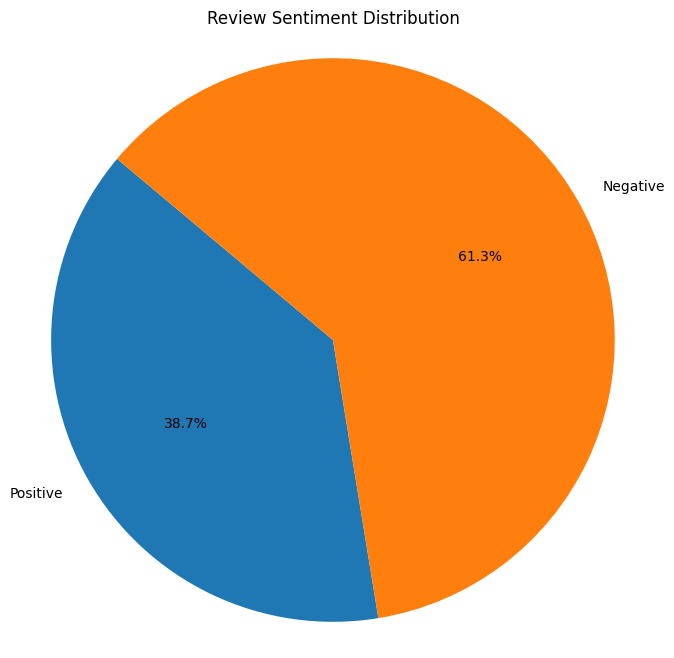

In [ ]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Assuming prediction_result is a PySpark DataFrame with columns 'features' and 'prediction'

# Aggregate counts of each class
class_counts = prediction_result.groupBy("prediction").count().collect()

# Extract counts for positive and negative classes
positive_count = next((row['count'] for row in class_counts if row['prediction'] == 1), 0)
negative_count = next((row['count'] for row in class_counts if row['prediction'] == 0), 0)

# Create labels and sizes for the pie chart
labels = ['Positive', 'Negative']
sizes = [positive_count, negative_count]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Review Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
d=prediction_result.toPandas()


In [ ]:
d.drop(['features'], axis=1)

,prediction
0,1.0
1,0.0
2,0.0
3,1.0
4,0.0
...,...
7995,0.0
7996,0.0
7997,1.0
7998,0.0
